## Perturbation of sequences
### Dataset: WIV04 
### Number of sequences = 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [5]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/wiv04',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/wiv04/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/wiv04/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/wiv04/..']

In [27]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [11]:
human_label = "Human"
perturbation_processed_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/WIV04/cov-S-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed/tl_tf_binary_sarscov2-S-WIV04ref.csv_WIV04.csv")

In [12]:
perturbed_output_df = pd.read_csv(perturbation_processed_output_file_path)
print(perturbed_output_df.shape)

(31826, 7)


In [13]:
perturbed_output_df.head()

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token
0,0.978961,0.021039,WIV04,Human,F,822,D
1,0.978766,0.021234,WIV04,Human,G,1266,U
2,0.978930,0.021070,WIV04,Human,S,11,L
3,0.978651,0.021349,WIV04,Human,F,1147,O
4,0.979135,0.020865,WIV04,Human,Q,948,S


In [14]:
orig_seq_df = perturbed_output_df[perturbed_output_df["orig_token"] == perturbed_output_df["new_token"]]
orig_seq_df

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token
6332,0.978684,0.021316,WIV04,Human,M,0,M


In [15]:
orig_seq_df_pred = orig_seq_df[human_label].values[0]
orig_seq_df_pred

0.97868425

In [16]:
pred_diff_col = f"{human_label}_pred_diff"
perturbed_output_df[pred_diff_col] = orig_seq_df_pred - perturbed_output_df[human_label]
perturbed_output_df[f"abs_{pred_diff_col}"] = perturbed_output_df[pred_diff_col].abs()
perturbed_output_df.head()

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.978961,0.021039,WIV04,Human,F,822,D,-0.000277,0.000277
1,0.978766,0.021234,WIV04,Human,G,1266,U,-0.000082,0.000082
2,0.978930,0.021070,WIV04,Human,S,11,L,-0.000246,0.000246
3,0.978651,0.021349,WIV04,Human,F,1147,O,0.000033,0.000033
4,0.979135,0.020865,WIV04,Human,Q,948,S,-0.000451,0.000451


### Distribution of prediction difference values

/tmp/ipykernel_1067793/2860024834.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perturbed_output_df["Human_pred_diff"])


<Figure size 432x288 with 0 Axes>

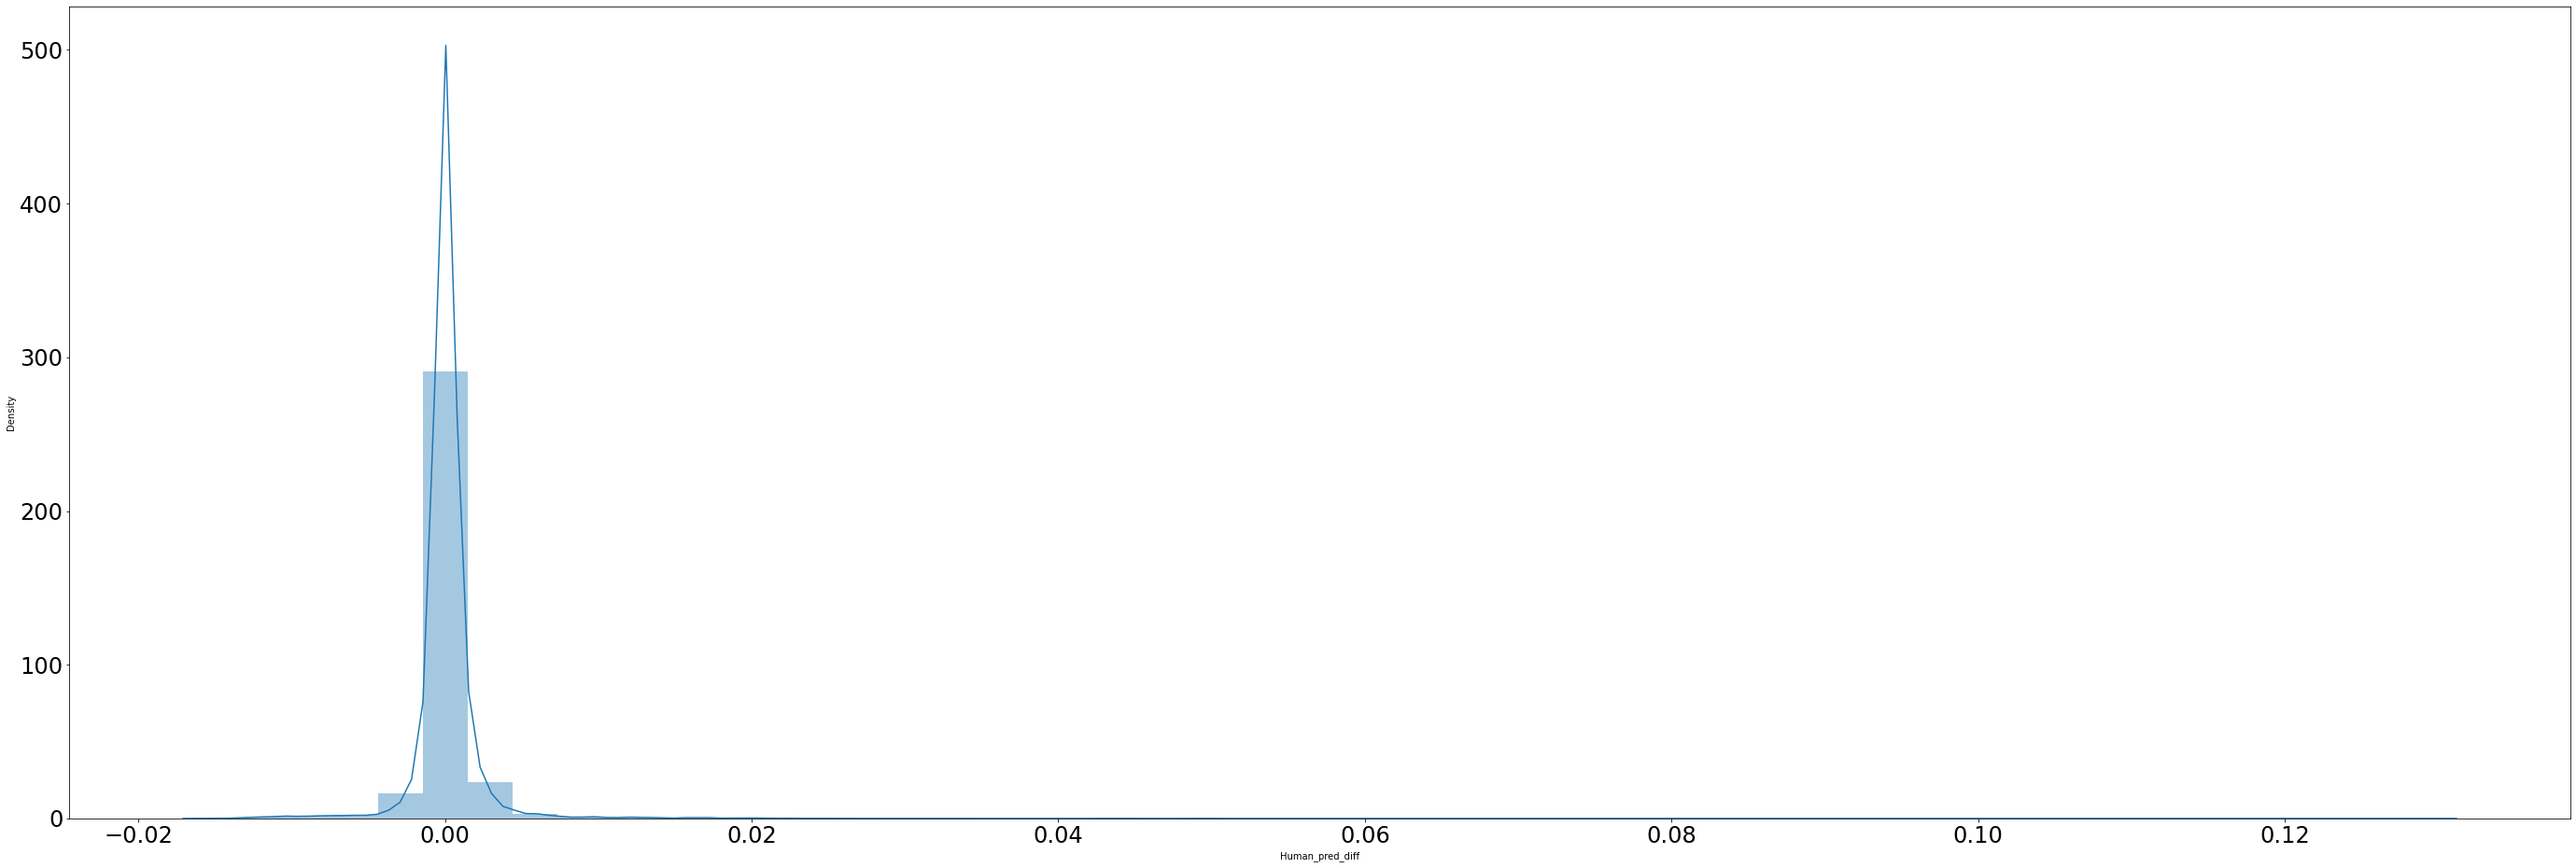

In [20]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
sns.distplot(perturbed_output_df["Human_pred_diff"])
plt.show()

In [23]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.016090,-0.003898,495,1.555332
1,-0.003898,0.008294,31064,97.605731
2,0.008294,0.020486,214,0.672406
3,0.020486,0.032677,29,0.091120
4,0.032677,0.044869,9,0.028279
5,0.044869,0.057061,5,0.015710
6,0.057061,0.069253,5,0.015710
7,0.069253,0.081444,2,0.006284
8,0.081444,0.093636,0,0.000000
9,0.093636,0.105828,1,0.003142


### Top 10 perturbations with highest change in prediction probability

In [25]:
perturbed_output_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
4758,0.848473,0.151527,WIV04,Human,N,147,W,0.130212,0.130212
16043,0.868649,0.131351,WIV04,Human,S,160,W,0.110035,0.110035
27074,0.883455,0.116545,WIV04,Human,K,146,W,0.095229,0.095229
30553,0.897665,0.102335,WIV04,Human,S,161,W,0.081020,0.081020
7545,0.908852,0.091148,WIV04,Human,L,188,W,0.069832,0.069832
2554,0.916914,0.083086,WIV04,Human,N,148,W,0.061770,0.061770
10132,0.918346,0.081654,WIV04,Human,N,187,W,0.060339,0.060339
26297,0.918505,0.081495,WIV04,Human,Y,159,W,0.060179,0.060179
7687,0.919362,0.080638,WIV04,Human,R,189,W,0.059322,0.059322
28583,0.919448,0.080552,WIV04,Human,E,190,W,0.059236,0.059236


In [26]:
df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values=pred_diff_col)
df

perturb_pos,0,1,2,3,4,5,6,7,8,9,...,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272
new_token,,,,,,,,,,,,,,,,,,,,,
A,-0.010407,0.016596,0.001025,0.001592,0.001070,0.001712,0.001214,0.001517,0.007093,0.002264,...,0.000084,0.000513,0.000800,0.000345,0.000263,0.001012,0.000662,0.000196,0.000051,0.000215
B,-0.010983,0.013035,-0.000039,0.000466,-0.000504,-0.000561,-0.000817,-0.000708,0.002074,-0.000287,...,-0.000240,0.000186,0.000407,-0.000082,-0.000199,0.000523,0.000237,-0.000159,-0.000248,-0.000092
C,-0.011865,0.011745,-0.000528,0.000197,-0.000944,-0.000694,-0.001185,-0.000952,0.002678,-0.000510,...,-0.001076,-0.000606,-0.000503,-0.000948,-0.001229,-0.000524,-0.000553,-0.000770,-0.000799,-0.000486
D,-0.010893,0.013496,0.000033,0.000237,-0.000622,-0.000938,-0.001175,-0.001058,0.000812,-0.000426,...,-0.000988,0.000092,0.000050,-0.000215,-0.000168,0.000278,0.000099,-0.000447,-0.000455,-0.000291
E,-0.010423,0.013445,0.000173,0.000534,-0.000471,-0.000813,-0.001120,-0.000978,0.000894,-0.000212,...,-0.000126,0.000289,0.000449,-0.000026,-0.000002,0.000656,0.000330,-0.000135,-0.000229,-0.000143
F,-0.016090,NaN,-0.001148,NaN,-0.000993,0.000897,-0.000018,0.000253,0.005928,0.000101,...,0.000360,0.000715,0.001030,0.000582,0.000263,0.001040,0.000775,0.000388,0.000167,0.000370
G,-0.010911,0.010432,-0.001733,-0.001492,-0.001971,-0.001798,-0.001870,-0.001600,0.000668,-0.000992,...,-0.000083,0.000312,0.000516,NaN,-0.000064,0.000648,0.000371,-0.000078,-0.000165,-0.000026
H,-0.010608,0.016739,0.001803,0.002831,0.001785,0.001659,0.001166,0.000892,0.003646,0.001342,...,0.000024,0.000429,0.000639,0.000167,0.000089,0.000760,0.000491,NaN,-0.000060,0.000145
I,-0.011214,0.011528,-0.000615,0.000141,-0.001012,-0.000709,-0.001351,-0.001296,0.002749,-0.001183,...,-0.000176,0.000172,0.000442,-0.000045,-0.000266,0.000597,0.000238,-0.000016,-0.000193,-0.000049


<Figure size 432x288 with 0 Axes>

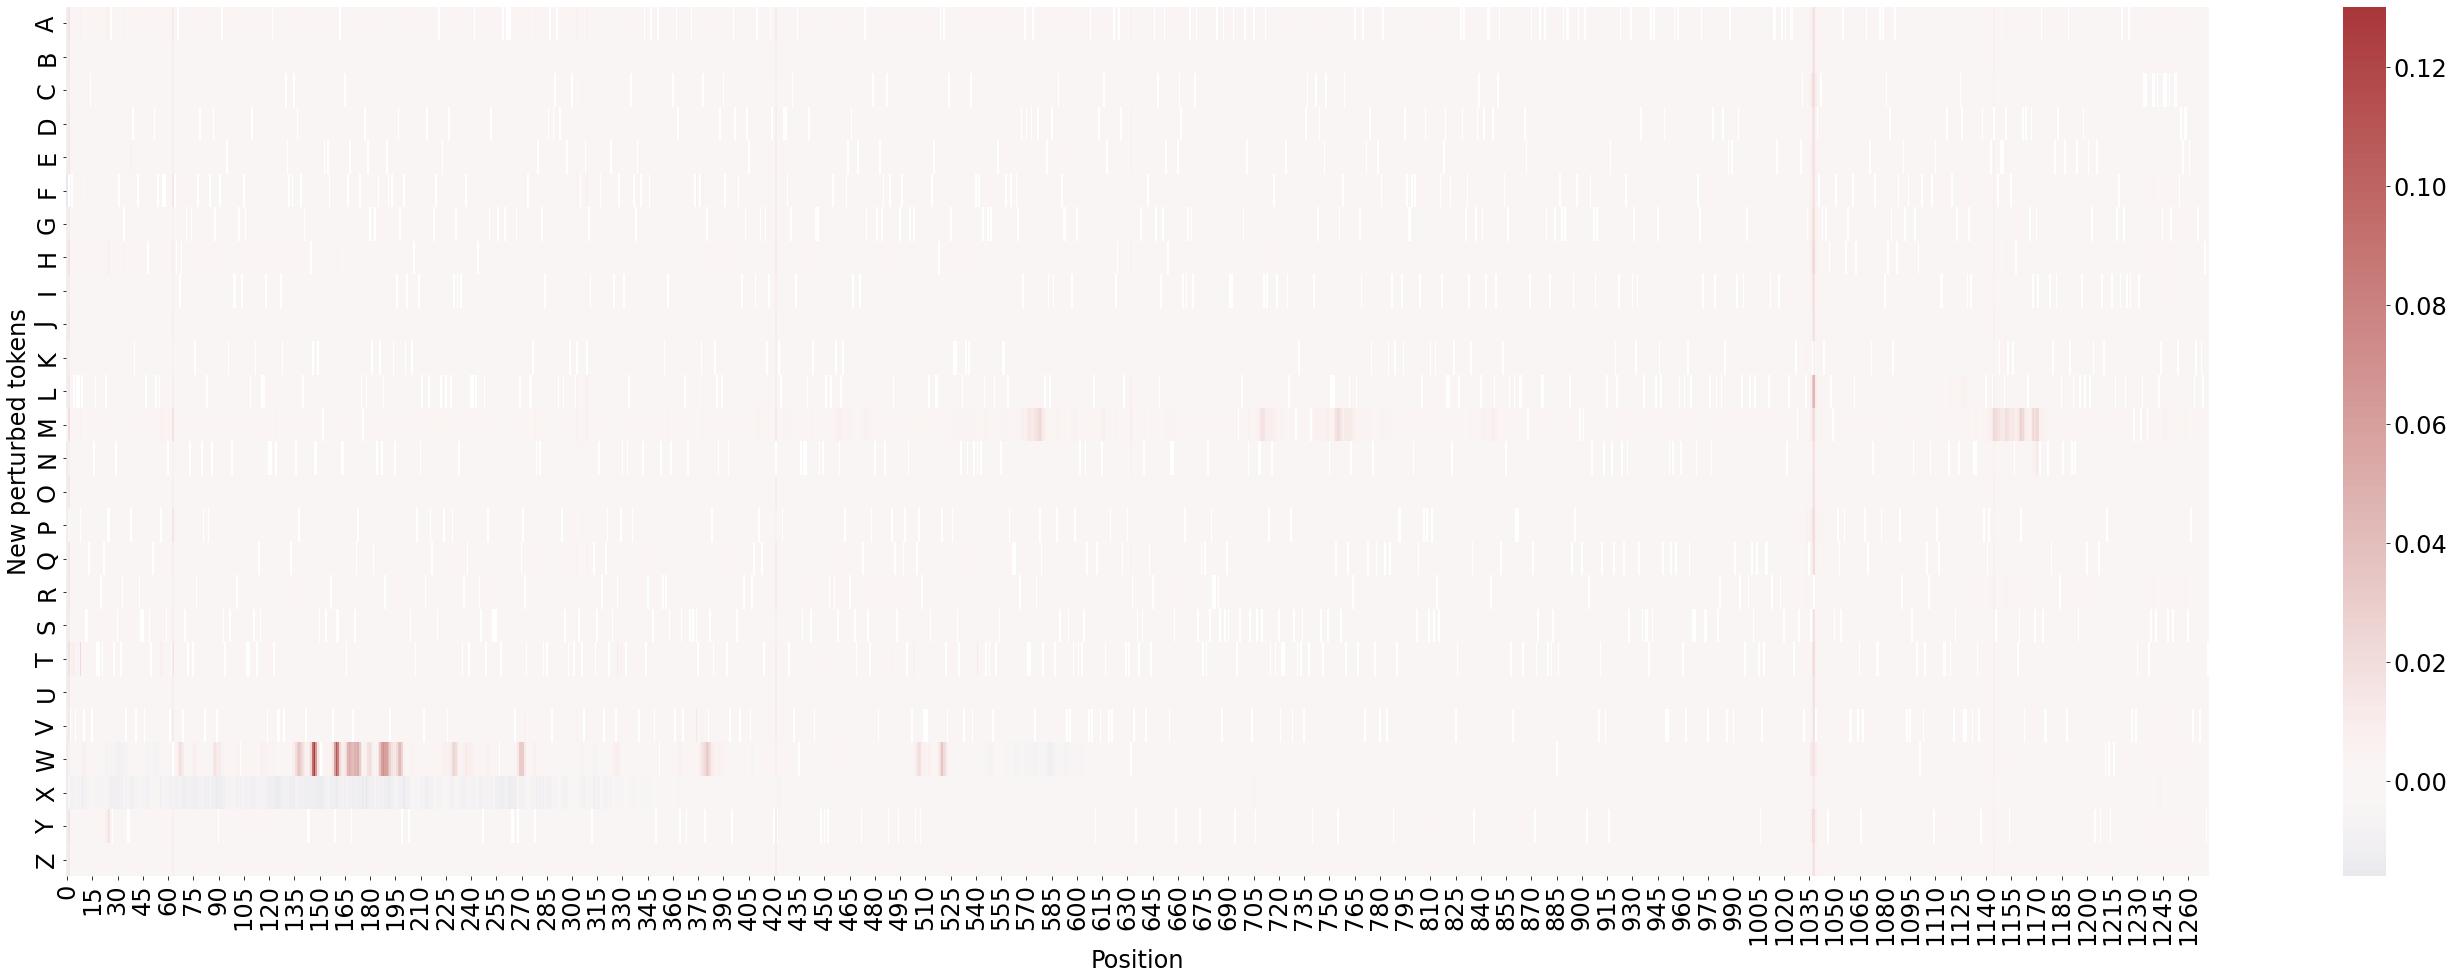

In [29]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [13]:
df.mean(axis=0)

perturb_pos
0      -0.011012
1       0.012325
2      -0.000568
3       0.000309
4      -0.000315
          ...   
1268    0.000536
1269    0.000269
1270   -0.000176
1271   -0.000246
1272   -0.000102
Length: 1273, dtype: float64

<Figure size 432x288 with 0 Axes>

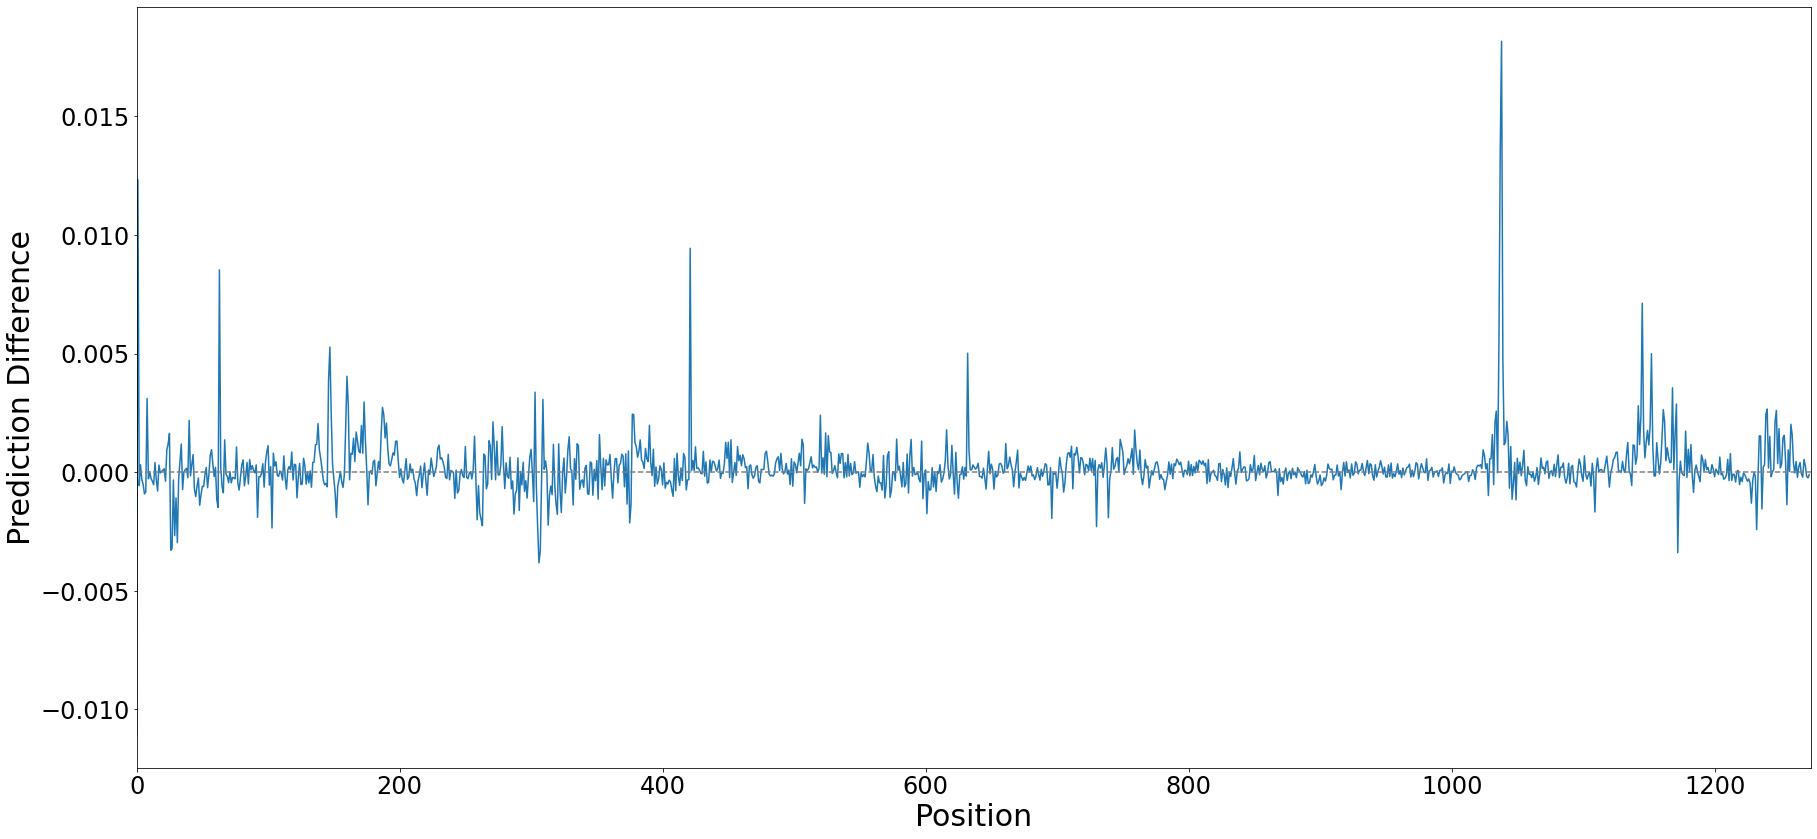

In [30]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
ax.set_xlim(0, 1273)
plt.show()